In [3]:
#Setup & Load Data
import pandas as pd

# Load your sales data
df = pd.read_csv('../data/sample_sales.csv')

# Preview
df.head()


,order_id,date,category,product_name,quantity,price,cost_price
0,1000,2023-09-04,Medicines,Antibiotic Ointment,3,30.30,27.20
1,1001,2024-04-08,Medicines,Paracetamol,3,19.09,15.48
2,1002,2024-05-02,Medicines,Cough Syrup,5,52.75,44.07
3,1003,2024-03-16,Medicines,Antibiotic Ointment,2,48.83,42.53
4,1004,2023-07-31,Medicines,Cough Syrup,5,95.82,58.57


In [5]:
# Create unique numeric IDs
df['user_id'] = df['order_id'].astype('category').cat.codes
df['item_id'] = df['product_name'].astype('category').cat.codes

# We'll use quantity as a proxy for implicit feedback (1 = purchased)
interactions = df[['user_id', 'item_id']].copy()
interactions['interaction'] = 1 



In [ ]:
#Build Dataset Class for PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

class InteractionDataset(Dataset):
    def __init__(self, interactions):
        self.users = torch.tensor(interactions['user_id'].values, dtype=torch.long)
        self.items = torch.tensor(interactions['item_id'].values, dtype=torch.long)
        self.labels = torch.tensor(interactions['interaction'].values, dtype=torch.float)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader


In [2]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())


2.7.1+cpu
CUDA Available: False


In [3]:
#Preprocess Your Data
import pandas as pd

# Load your sales data
df = pd.read_csv("../data/sample_sales.csv")

# Simulate customer_id from order_id
df['customer_id'] = df['order_id'] % 5000  # just a consistent id for demonstration

# Assign product_id from product_name using category encoding
df['product_id'] = df['product_name'].astype('category').cat.codes

# Aggregate interactions: each purchase → implicit interest
interactions = df.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index()
interactions['interaction'] = 1  # treat all purchases as a "like" or interest

interactions = interactions[['customer_id', 'product_id', 'interaction']]
print(interactions.head())


   customer_id  product_id  interaction
0            0          21            1
1            1          18            1
2            2          18            1
3            3          21            1
4            4           2            1


In [4]:
#Define the PyTorch Dataset
import torch
from torch.utils.data import Dataset, DataLoader

class InteractionDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['customer_id'].values, dtype=torch.long)
        self.items = torch.tensor(data['product_id'].values, dtype=torch.long)
        self.labels = torch.tensor(data['interaction'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

dataset = InteractionDataset(interactions)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
#Build the Recommendation Model
import torch.nn as nn

class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item):
        user_vec = self.user_embedding(user)
        item_vec = self.item_embedding(item)
        return (user_vec * item_vec).sum(1)

num_users = interactions['customer_id'].nunique()
num_items = interactions['product_id'].nunique()
model = RecommenderNet(num_users, num_items)


In [7]:
# Train the Model
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5):
    total_loss = 0
    for user, item, label in dataloader:
        optimizer.zero_grad()
        pred = model(user, item)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 83.7026
Epoch 2, Loss: 462.6183
Epoch 3, Loss: 283.4762
Epoch 4, Loss: 131.7244
Epoch 5, Loss: 78.2674


In [11]:
# Generate Recommendations
user_id = 2850 # Any valid customer_id (from the earlier generated ids)
user_tensor = torch.tensor([user_id] * num_items)
item_tensor = torch.arange(num_items)

# Get scores
with torch.no_grad():
    scores = model(user_tensor, item_tensor)

top_items = torch.topk(scores, 5).indices.numpy()

# Get product names
product_lookup = dict(enumerate(df['product_name'].astype('category').cat.categories))
recommended_products = [product_lookup[i] for i in top_items]

print("Top Product Recommendations for User", user_id, ":\n", recommended_products)


Top Product Recommendations for User 2850 :
 ['Fried Rice', 'Shampoo', 'Sweater', 'Smart Watch', 'Pizza']


C:\Users\himan\AppData\Local\Temp\ipykernel_32328\1997403285.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


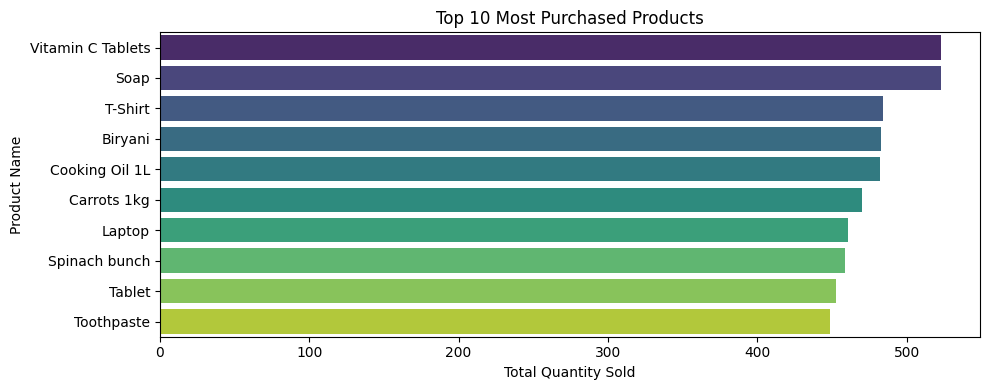

In [14]:
# Visualize Top Products & Active Users
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 most purchased products
top_products = df.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()




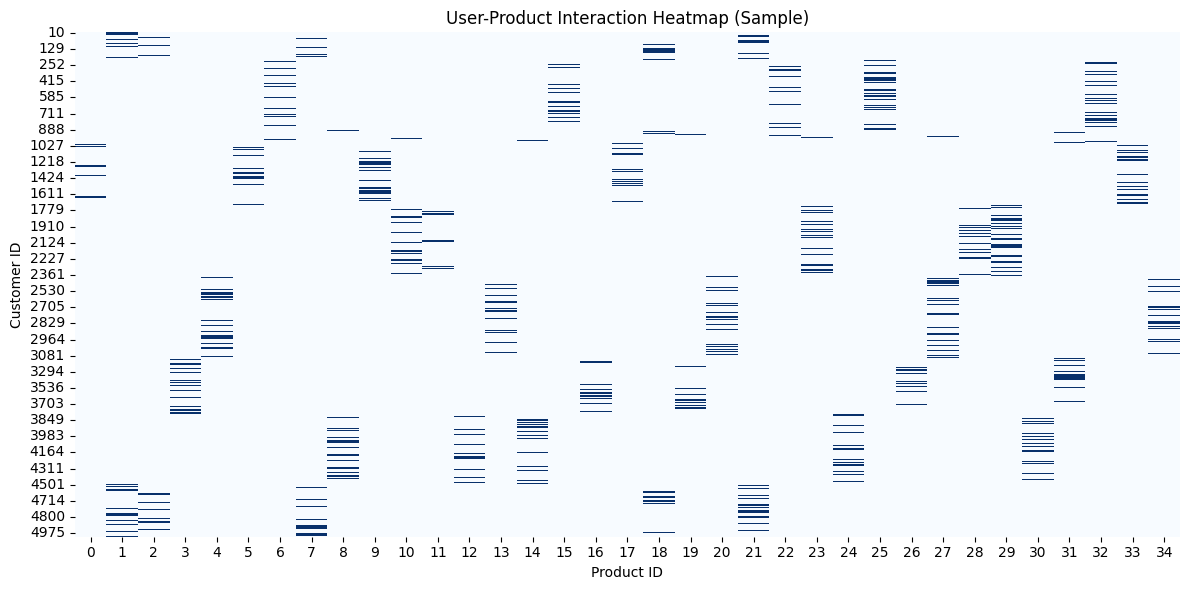

In [15]:
#Heatmap of User–Product Interaction Matrix (Sample)
# Create interaction matrix for a sample
sample = interactions.sample(500)  # reduce size for plot
pivot = sample.pivot(index='customer_id', columns='product_id', values='interaction').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='Blues', cbar=False)
plt.title('User-Product Interaction Heatmap (Sample)')
plt.xlabel('Product ID')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


In [16]:
# Save model
torch.save(model.state_dict(), 'recommender_model.pth')

# To load later
model_loaded = RecommenderNet(num_users, num_items)
model_loaded.load_state_dict(torch.load('recommender_model.pth'))
model_loaded.eval()


RecommenderNet(
  (user_embedding): Embedding(5000, 64)
  (item_embedding): Embedding(35, 64)
)

C:\Users\himan\AppData\Local\Temp\ipykernel_32328\850951688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=profit_df.values, y=profit_df.index, palette='mako')


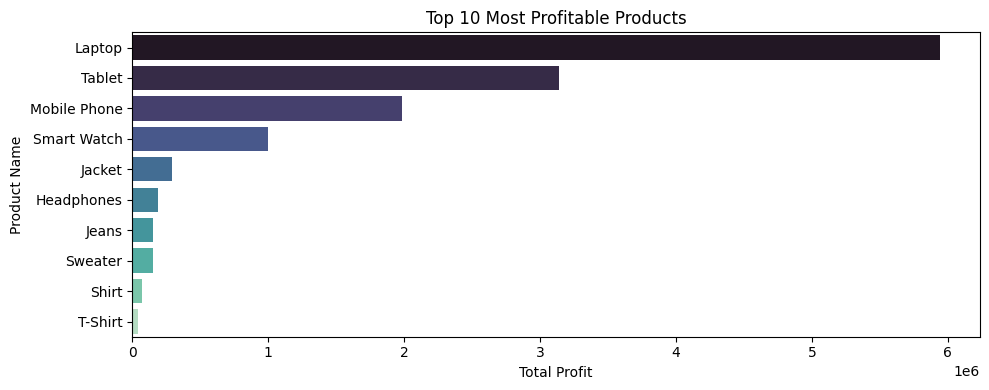

In [17]:
df['profit'] = (df['price'] - df['cost_price']) * df['quantity']
profit_df = df.groupby('product_name')['profit'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=profit_df.values, y=profit_df.index, palette='mako')
plt.title('Top 10 Most Profitable Products')
plt.xlabel('Total Profit')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()


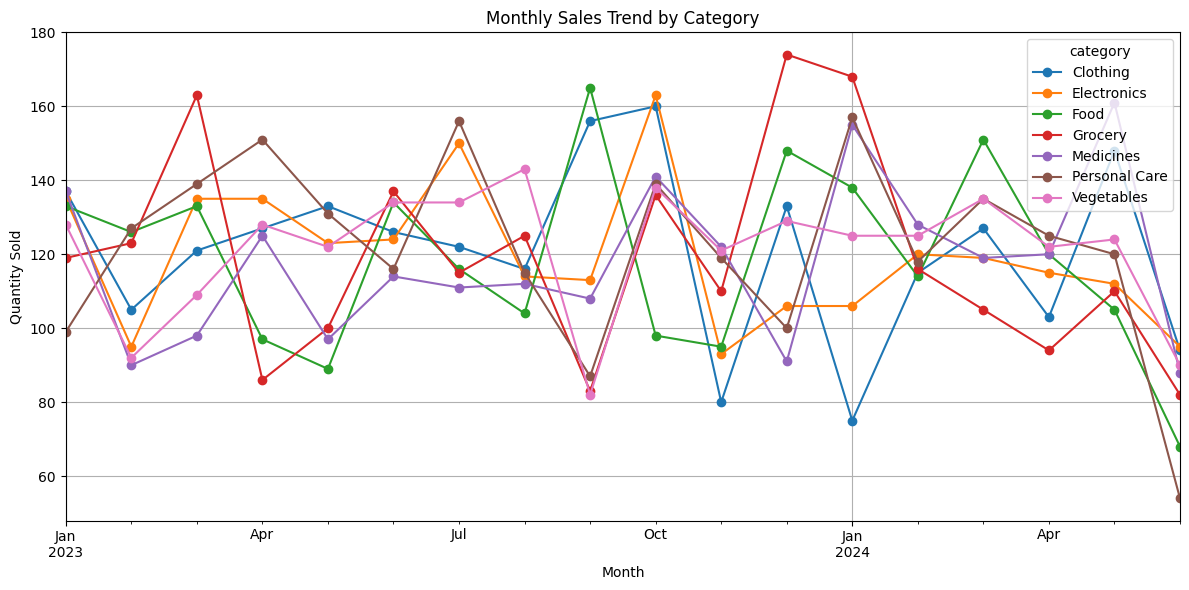

In [18]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

monthly_category_sales = df.groupby(['month', 'category'])['quantity'].sum().unstack().fillna(0)

monthly_category_sales.plot(figsize=(12, 6), marker='o')
plt.title('Monthly Sales Trend by Category')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()
